In [51]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim, autograd

from mymodel import DeepONet, NN1, NN2

In [18]:
DATADIR = "../dataset/mini_alibaba/"

d = np.load(f"{DATADIR}mini_alibaba_train_high.npz", allow_pickle=True)
X_train_high = (d["X_train0"].astype(np.float32), d["X_train1"].astype(np.float32))
y_train_high = d["y_train"].astype(np.float32)
# print(d['X_train0'].shape)
# print(d['X_train1'].shape)
# print(d['y_train'].shape)
# lent = len(d['X_train0'])
# print(f"synthetic high fidelity data (len={lent}):")
# print(d['X_train0'])

d = np.load(f"{DATADIR}mini_alibaba_train_low.npz", allow_pickle=True)
X_train_low = (d["X_train0"].astype(np.float32), d["X_train1"].astype(np.float32))
y_train_low = d["y_train"].astype(np.float32)
# print(d['X_train0'].shape)
# print(d['X_train1'].shape)
# print(d['y_train'].shape)
# lent = len(d['X_train0'])
# print(f"synthetic low fidelity data (len={lent}):")
# print(np.around(d['X_train0'], decimals=2))

In [44]:
# Choose a network
m = 5
dim_x = 3

net_h = DeepONet(
    [m, 40, 40],
    [dim_x, 40, 40],
    "relu",
    "Glorot normal",
)

net_d = DeepONet(
    [m, 40, 40],
    [dim_x, 40, 40],
    "relu",
    "Glorot normal",
)

In [45]:
inputs = tuple(map(lambda x: torch.as_tensor(x).requires_grad_(), X_train_high))

optimizer = optim.Adam(net_h.parameters(), lr=0.001)

it = 0
loss_value = 1
losses = []
while loss_value > 10e-2:
    pred_h = net_h(inputs)
    loss = torch.mean(torch.square(pred_h - torch.from_numpy(y_train_high).float().to(pred_h.device)))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_value = loss.item()
    if it % 1000 == 0:
        print('It:', it, 'Loss', loss.item())
    losses.append(loss_value)
    it = it + 1


# plt.style.use('default')
# plt.plot(losses)
# plt.show()

# save model
torch.save(net_h.state_dict(), "net_h.pt")

It: 0 Loss 592.5763549804688


In [46]:
inputs_low = tuple(map(lambda x: torch.as_tensor(x).requires_grad_(), X_train_low))

optimizer_d = optim.Adam(net_d.parameters(), lr=0.001)

it = 0
loss_value = 1
while loss_value > 5e-3:
    pred_d = net_d(inputs_low)
    loss_d = torch.mean(torch.square(pred_d - torch.from_numpy(y_train_low).float().to(pred_d.device)))

    optimizer_d.zero_grad()
    loss_d.backward()
    optimizer_d.step()
    loss_value = loss_d.item()
    if it % 1000 == 0:
        print('It:', it, 'Loss', loss_d.item())
    it = it + 1

# save model
torch.save(net_d.state_dict(), "net_d.pt")

It: 0 Loss 37.756103515625


MSE with true data:  0.14403735


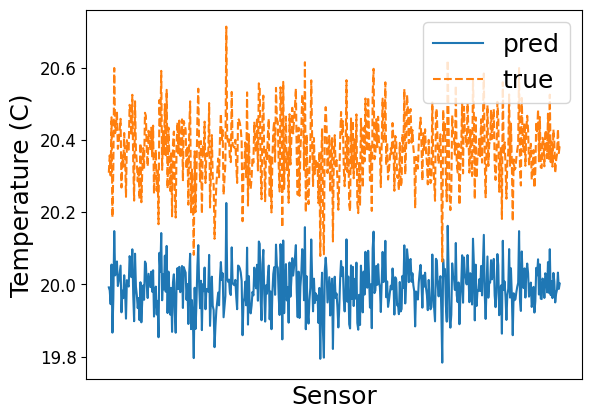

In [83]:
# test on low fidelity data
net_h.load_state_dict(torch.load("net_h.pt"))

inputs_low_test = tuple(map(lambda x: torch.as_tensor(x).requires_grad_(), X_train_low))

pred_h_low = net_h(inputs_low_test)

# MSE with true data
print("MSE with true data: ", np.mean(np.square(pred_h_low.detach().cpu().numpy() - y_train_low)))

# font size
plt.rcParams.update({'font.size': 14})
plt.plot(pred_h_low.detach().cpu().numpy(), label="pred")
plt.plot(y_train_low, label="true", linestyle='--')
plt.ylabel("Temperature (C)", fontsize=18)
plt.xlabel("Sensor", fontsize=18)
plt.xticks([])
plt.yticks(fontsize=12)
plt.legend(fontsize=18, loc='upper right')
plt.savefig("pred_low.pdf", dpi=300)
plt.show()

In [56]:
net_d.load_state_dict(torch.load("net_d.pt"))
def diff_low(x):
    y = net_d(x)
    # dy_dx
    return autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

alpha = torch.tensor([0.5])
net_l = NN1(9, 20, 4, 1)
net_e = NN2(9, 10, 2, 1)

optimizer_M = optim.AdamW([{'params': net_l.parameters(), 'weight_decay': 0.01},
                          {'params': net_h.parameters()},
                          {'params': net_e.parameters(), 'weight_decay': 0.01}], lr=1e-4)

net_h.load_state_dict(torch.load("net_h.pt"))

x_hi = tuple(map(lambda x: torch.as_tensor(x).requires_grad_(), X_train_high))
x_lo = tuple(map(lambda x: torch.as_tensor(x).requires_grad_(), X_train_low))
y_hi = torch.from_numpy(y_train_high).float()
y_lo = torch.from_numpy(y_train_low).float()
y_lo_d = diff_low(x_lo)

it = 0
while it < 10000:
    pred_h = net_h(x_lo)

    grads = autograd.grad(outputs=pred_h, inputs=x_lo,
                          grad_outputs=torch.ones_like(pred_h),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]
    
    loss_L = torch.mean(torch.square(pred_h - y_lo.to(pred_h.device))) + \
            torch.mean(torch.sum(torch.square(grads - y_lo_d.to(pred_h.device)), 1, keepdim=True))

    pred_2h = net_h(x_hi)
    pred_2 = alpha * net_l(torch.cat((x_hi[0], x_hi[1], pred_2h), 1)) + \
              (1 - alpha) * net_e(torch.cat((x_hi[0], x_hi[1], pred_2h), 1))
    loss_E = torch.mean(torch.square(pred_2 - y_hi.to(pred_h.device))) + loss_L
    loss2_value = loss_E.item()
    
    optimizer_M.zero_grad()
    loss_E.backward(retain_graph=True)
    optimizer_M.step()

    if it % 1000 == 0:
        print('It:', it, 'Loss', loss_E.item())
        # save model
        torch.save(net_h.state_dict(), "net_h_mf.pt")
    it = it + 1

It: 0 Loss 501.7613525390625
It: 1000 Loss 0.588131844997406
It: 2000 Loss 0.2637885808944702
It: 3000 Loss 0.23752102255821228
It: 4000 Loss 0.18070849776268005
It: 5000 Loss 0.005101250484585762
It: 6000 Loss 0.0030534015968441963
It: 7000 Loss 0.002093089511618018
It: 8000 Loss 0.0015923434402793646
It: 9000 Loss 0.0013158550718799233


MSE with true data:  0.0009291199
MAE with true data:  0.023806


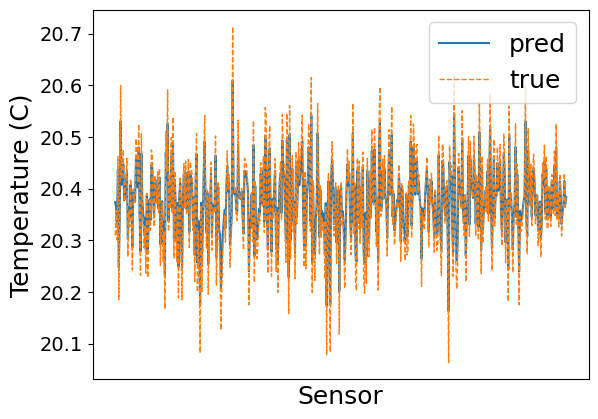

In [63]:
# test on low fidelity data
net_h.load_state_dict(torch.load("net_h_mf.pt"))

inputs_low_test = tuple(map(lambda x: torch.as_tensor(x).requires_grad_(), X_train_low))

pred_h_low = net_h(inputs_low_test)

# MSE with true data
print("MSE with true data: ", np.mean(np.square(pred_h_low.detach().cpu().numpy() - y_train_low)))
# MAE with true data
print("MAE with true data: ", np.mean(np.abs(pred_h_low.detach().cpu().numpy() - y_train_low)))
# plt.plot(y_train_low, label="true", linewidth=1)
# plt.plot(pred_h_low.detach().cpu().numpy(), label="pred",linewidth=1)
# plt.legend()
# plt.show()

plt.rcParams.update({'font.size': 14})
plt.plot(pred_h_low.detach().cpu().numpy(), label="pred")
plt.plot(y_train_low, label="true", linestyle='--', linewidth=1)
plt.ylabel("Temperature (C)", fontsize=18)
plt.xlabel("Sensor", fontsize=18)
plt.xticks([])
plt.yticks(fontsize=14)
plt.legend(fontsize=18, loc='upper right')
plt.savefig("pred_mf.pdf", dpi=300)
plt.show()

MSE with true data:  0.106331944


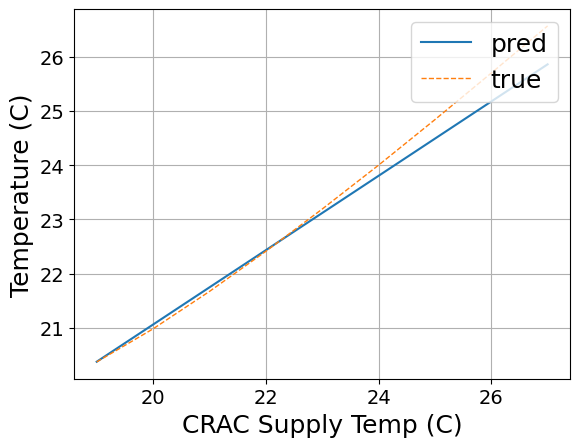

In [81]:
# test on low fidelity data
net_h.load_state_dict(torch.load("net_h_mf.pt"))

inputs_high_test = tuple(map(lambda x: torch.as_tensor(x).requires_grad_(), X_train_high))

pred_h_high = net_h(inputs_high_test)

# MSE with true data
print("MSE with true data: ", np.mean(np.square(pred_h_high.detach().cpu().numpy() - y_train_high)))

# plt.plot(y_train_high, label="true", linewidth=1, color='orange')
# plt.plot(pred_h_high.detach().cpu().numpy(), label="pred",linewidth=1, color='blue')
# plt.legend()
# plt.show()


plt.rcParams.update({'font.size': 14})
plt.plot(X_train_high[0].T[0],pred_h_high.detach().cpu().numpy(), label="pred")
plt.plot(X_train_high[0].T[0],y_train_high, label="true", linestyle='--', linewidth=1)
plt.ylabel("Temperature (C)", fontsize=18)
plt.xlabel("CRAC Supply Temp (C)", fontsize=18)
# plt.xticks([])
plt.yticks(fontsize=14)
plt.legend(fontsize=18, loc='upper right')
plt.grid()
plt.savefig("ext_mf.pdf", dpi=300)
plt.show()

MSE with true data:  0.4032538


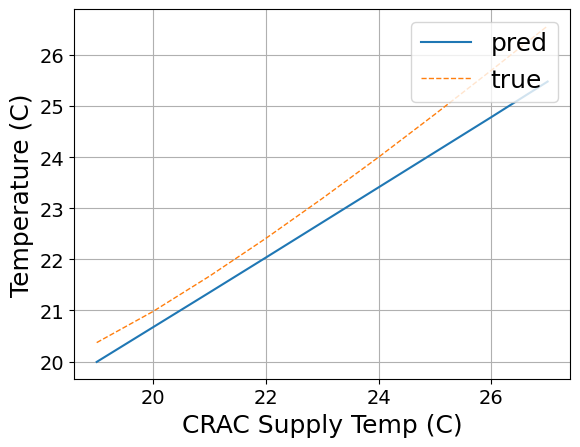

In [82]:
# test on low fidelity data
net_h.load_state_dict(torch.load("net_h.pt"))

inputs_high_test = tuple(map(lambda x: torch.as_tensor(x).requires_grad_(), X_train_high))

pred_h_high = net_h(inputs_high_test)

# MSE with true data
print("MSE with true data: ", np.mean(np.square(pred_h_high.detach().cpu().numpy() - y_train_high)))

# plt.plot(y_train_high, label="true", linewidth=1, color='orange')
# plt.plot(pred_h_high.detach().cpu().numpy(), label="pred",linewidth=1, color='blue')
# plt.legend()
# plt.show()

plt.rcParams.update({'font.size': 14})
plt.plot(X_train_high[0].T[0],pred_h_high.detach().cpu().numpy(), label="pred")
plt.plot(X_train_high[0].T[0],y_train_high, label="true", linestyle='--', linewidth=1)
plt.ylabel("Temperature (C)", fontsize=18)
plt.xlabel("CRAC Supply Temp (C)", fontsize=18)
# plt.xticks([])
plt.yticks(fontsize=14)
plt.legend(fontsize=18, loc='upper right')
plt.grid()
plt.savefig("ext_hf.pdf", dpi=300)
plt.show()